In [2]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

In [7]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


In [8]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

In [9]:
initialDf_PETR4 = getPeriod(df, '2016.01.04','2021.06.01', True)
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,LB_open,UB_high,LB_high,UB_low,LB_low,UB_close,LB_close,d-1_open,d-1_high,d-1_low,d-1_close,d-2_open,d-2_high,d-2_low,d-2_close,d-3_open,d-3_high,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2016.01.04,5.96,6.38,5.94,6.23,5.960000,6.380000,5.940000,6.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016.01.05,6.28,6.35,6.00,6.06,6.280000,6.350000,6.000000,6.060000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.96,6.38,5.94,6.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016.01.06,5.92,5.93,5.80,5.80,5.920000,5.930000,5.800000,5.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.28,6.35,6.00,6.06,5.96,6.38,5.94,6.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016.01.07,5.61,5.83,5.51,5.68,5.610000,5.830000,5.510000,5.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.92,5.93,5.80,5.80,6.28,6.35,6.00,6.06,5.96,6.38,5.94,6.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016.01.08,5.79,5.85,5.56,5.69,6.053333,6.220000,5.913333,6.030000,6.405842,5.418158,6.615796,5.520204,6.202545,5.321455,6.378498,5.405502,5.61,5.83,5.51,5.68,5.92,5.93,5.80,5.80,6.28,6.35,6.00,6.06,5.96,6.38,5.94,6.23,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,25.751281,26.745428,26.018572,26.105344,25.526656,26.470349,25.609651,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
1335,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,25.727913,26.748720,26.003280,26.101899,25.550101,26.471798,25.600202,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
1336,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,25.762449,27.187686,25.848314,26.267099,25.468901,27.180120,25.307880,26.08,26.25,25.77,25.91,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
1337,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,25.504343,27.560157,25.747843,26.948670,25.103330,27.435810,25.244190,26.20,27.02,26.15,26.99,26.08,26.25,25.77,25.91,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [10]:
import pdb

In [8]:
df_importance = []
def exp041(df, normalizer = "", inputColumns = [], TRAIN_BEGIN = '2018.04.02', TRAIN_END = '2021.02.03', VALID_BEGIN = '2021.02.04', VALID_END = '2021.04.05', TEST_BEGIN = '2021.04.06', TEST_END = '2021.06.01'):
    
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_valid = getPeriod(df, VALID_BEGIN, VALID_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_valid = df_valid.drop(['date', 'high', 'low', 'close'], axis=1)
        y_valid = df_valid[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_valid = df_valid[inputColumns]
        y_valid = df_valid[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    if(normalizer == "minmax"):
        scaler = MinMaxScaler()
        scaler_alvo = MinMaxScaler()
    elif(normalizer == "standard"):
        scaler = StandardScaler()
        scaler_alvo = StandardScaler()
    elif(normalizer == "power"):
        scaler = PowerTransformer()
        scaler_alvo = PowerTransformer()

    if(normalizer != ""):
        # Selecionar apenas colunas numéricas para normalizar
        numeric_cols = x_train.select_dtypes(include=['number']).columns
        
        scaler.fit(pd.concat([x_train[numeric_cols], x_valid[numeric_cols]]))

        # Aplicar normalização apenas nas colunas numéricas
        x_train[numeric_cols] = scaler.transform(x_train[numeric_cols])
        x_valid[numeric_cols] = scaler.transform(x_valid[numeric_cols])
        x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

        y_train = pd.DataFrame(scaler_alvo.fit_transform(y_train),columns=y_train.columns,index=y_train.index)
        y_valid = pd.DataFrame(scaler_alvo.transform(y_valid),columns=y_valid.columns,index=y_valid.index)
        y_test = pd.DataFrame(scaler_alvo.transform(y_test),columns=y_test.columns,index=y_test.index)

    best_y_pred = None
    best_uncertainty_valid = None
    best_uncertainty_test = None
    best_errorMax = (float('inf'), float('inf'))
    best_errorMin = (float('inf'), float('inf'))    

    for i in range(1, 5):    
        rf = RandomForestRegressor(n_estimators = 300)
        rf.fit(x_train, y_train)
        # Obter previsões individuais de cada árvore
        predictions_per_tree = np.array([tree.predict(x_test) for tree in rf.estimators_])
        predictions_per_tree_valid = np.array([tree.predict(x_valid) for tree in rf.estimators_])
        # Média das predições (previsão final)
        y_pred = predictions_per_tree.mean(axis=0)
        # Desvio padrão como medida de incerteza/confiança
        
        uncertainty_valid = predictions_per_tree_valid.std(axis=0)
        uncertainty_test = predictions_per_tree.std(axis=0)
        pdb.set_trace()
        errorMax = mape(y_test['high'],y_pred[:,0])
        errorMin = mape(y_test['low'],y_pred[:,1])
        printResult(errorMax, 'High')
        printResult(errorMin, 'Low')

        if errorMax[1] < best_errorMax[1] and errorMin[1] < best_errorMin[1]:
            best_y_pred = y_pred
            best_uncertainty_valid = uncertainty_valid
            best_uncertainty_test = uncertainty_test
            best_errorMax = errorMax
            best_errorMin = errorMin
    
    if(normalizer != ""):
        y_pred = scaler_alvo.inverse_transform(y_pred)
        y_test = scaler_alvo.inverse_transform(y_test)
    return best_errorMax, best_errorMin, best_y_pred, y_test, best_uncertainty_test, best_uncertainty_valid

In [11]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    df = calculateEMA(df,DAYS,newColumns)
    df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

In [12]:
pd.set_option('display.max_columns', None)
df = create_df('PETR4')

In [13]:
df.shape

(988, 37)

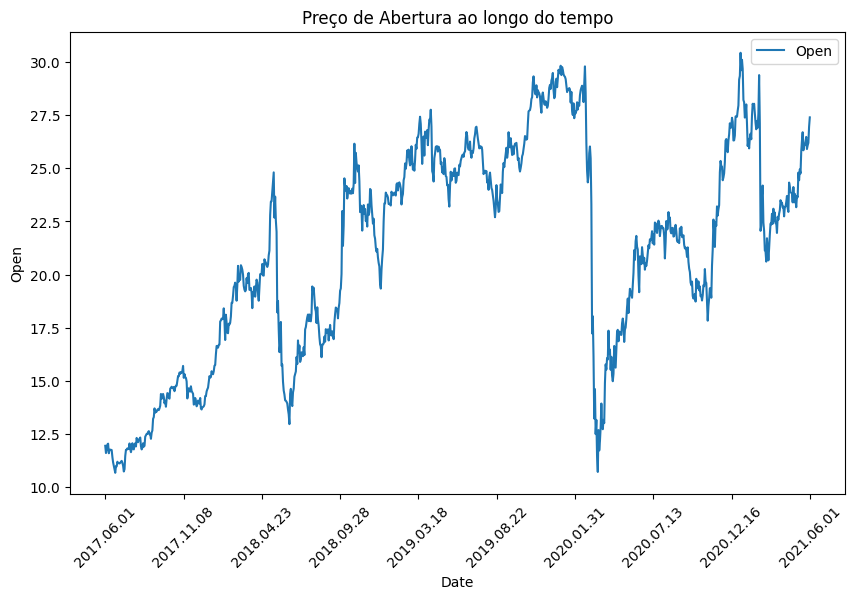

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Preço de Abertura ao longo do tempo')
plt.legend()

# Reduzir o número de pontos no eixo x
num_ticks = 10  # Número de ticks no eixo x
plt.xticks(np.linspace(0, len(df['date']) - 1, num_ticks), rotation=45)

plt.show()

In [ ]:
def exp_chronos(df, target_col='open', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):

    # 1. Separar os períodos
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    # 2. Selecionar a série alvo
    y_train = df_train[target_col].values
    y_valid = df_valid[target_col].values
    y_test  = df_test[target_col].values

    # 3. Preparar entrada para Chronos
    serie_torch = torch.tensor(np.concatenate([y_train, y_valid]), dtype=torch.float32)
    
    pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="auto")
    quantiles, mean = pipeline.predict_quantiles(
        context=serie_torch,
        prediction_length=prediction_length,
        quantile_levels=[0.1, 0.5, 0.9]
    )

    #4.Resultados
    y_pred_mean = mean[0].numpy()
    y_test_orig = y_test[-prediction_length:]
    q10 = quantiles[0, :, 0].numpy()
    q90 = quantiles[0, :, 2].numpy()
    uncertainty = q90 - q10


    return [y_test_orig, y_pred_mean, uncertainty]

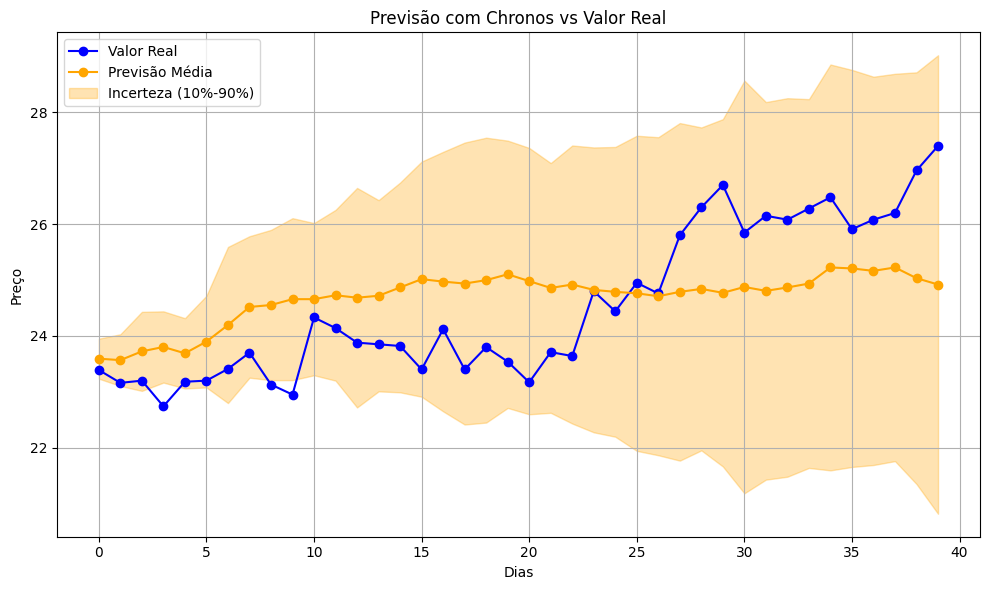

In [21]:
y_test_orig, y_pred_mean, uncertainty = exp_chronos(df, prediction_length=40)

# Criar eixo de tempo
dias = np.arange(len(y_test_orig))

# Calcular faixa de incerteza (intervalo 90% - 10%)
inferior = y_pred_mean - (uncertainty / 2)
superior = y_pred_mean + (uncertainty / 2)

plt.figure(figsize=(10, 6))

# Linha real (azul)
plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

# Linha prevista (laranja)
plt.plot(dias, y_pred_mean, label='Previsão Média', color='orange', marker='o')

# Faixa de incerteza (sombreada)
plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

# Rótulos e legendas
plt.title('Previsão com Chronos vs Valor Real')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Você está dizendo:

Me mostre, para os próximos 5 dias:

O valor mais pessimista (quantil 0.1)

O valor mais provável (mediana, quantil 0.5)

O valor mais otimista (quantil 0.9)

📊 Exemplo numérico (dia 1)
Quantil	Valor	Interpretação
0.1	    23.1	10% das previsões ficam abaixo de 23.1 → valor conservador
0.5	    24.0	Previsão mais provável (mediana)
0.9	    25.4	90% das previsões ficam abaixo de 25.4 → valor otimista
